<a href="https://colab.research.google.com/github/pam-lab/JupyterFiles/blob/main/NLP_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

In [2]:
!pip install -Uqq transformers
!pip install -Uqq hazm
!pip install -Uqq datasets
!pip install -Uqq seqeval

     |████████████████████████████████| 4.7 MB 33.9 MB/s 
     |████████████████████████████████| 101 kB 13.7 MB/s 
     |████████████████████████████████| 6.6 MB 59.3 MB/s 
     |████████████████████████████████| 596 kB 70.1 MB/s 
     |████████████████████████████████| 316 kB 10.9 MB/s 
     |████████████████████████████████| 1.4 MB 25.6 MB/s 
     |████████████████████████████████| 233 kB 10.7 MB/s 
     |████████████████████████████████| 365 kB 31.2 MB/s 
     |████████████████████████████████| 141 kB 74.0 MB/s 
     |████████████████████████████████| 212 kB 76.8 MB/s 
     |████████████████████████████████| 127 kB 72.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 43 kB 2.4 MB/s 


In [3]:
import numpy as np
import pandas as pd

import hazm

import transformers 
from transformers import AutoTokenizer, AutoConfig
from transformers import TFAutoModelForTokenClassification
import itertools
from datasets import Dataset
from datasets import load_metric
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification


import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

import os
from IPython.display import display, HTML, clear_output
from ipywidgets import widgets, Layout

print()
print('tensorflow', tf.__version__)
print('transformers', transformers.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
print()

if tf.test.gpu_device_name() != '/device:GPU:0':
    print()
    print('WARNING: GPU device not found.')
else:
    print()
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))


tensorflow 2.8.2
transformers 4.21.0
numpy 1.21.6
pandas 1.3.5


SUCCESS: Found GPU: /device:GPU:0


### Fine-tune model with our data

In [4]:
!gdown 1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
!gdown 1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
!gdown 1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw

Downloading...
From: https://drive.google.com/uc?id=1oJjoGK15-RD7IHm8-k0DhSXFlWDaq201
To: /content/ner-train.csv
100% 6.85M/6.85M [00:00<00:00, 311MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AzXg9YVaXCAzalr57IpP1sNbWBBbZrqI
To: /content/ner-test.csv
100% 383k/383k [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LXZrlNFr8jKhVF5ETEu6OwnuwPfrIyLw
To: /content/ner-eval.csv
100% 348k/348k [00:00<00:00, 119MB/s]


In [5]:
data_train = pd.read_csv('ner-train.csv')
data_val = pd.read_csv('ner-eval.csv')
data_test = pd.read_csv('ner-test.csv')

In [6]:
len(data_train), len(data_val), len(data_test)

(4050, 225, 225)

In [7]:
def clean_alt_list(list_):
    list_ = list_.replace('[','').replace(']','').split(',')
    return [item.replace("'","").strip() for item in list_]

In [8]:
def convert_to_list(data):
    data['token'] = data['token'].apply(clean_alt_list)
    data['labels'] = data['labels'].apply(clean_alt_list)

In [9]:
convert_to_list(data_train)
convert_to_list(data_val)
convert_to_list(data_test)

In [10]:
data_train

,token,labels
0,"[«صندلی, داغ», و, «شب, آرام», در, نوروزی, های,...","[o, o, o, o, o, o, B-DAT, I-DAT, o, o]"
1,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
2,"[به, گزارش, خبرگزاری, مهر, به, نقل, از, روابط,...","[o, o, B-ORG, I-ORG, I-ORG, o, o, B-ORG, I-ORG..."
3,"[نشان, درجه, یک, هنری, استاد, «محمدرضا, اسحاقی...","[o, o, o, o, o, o, B-PER, o, o, o, o, o, o, o, o]"
4,"[به, گزارش, خبرنگار, خبرگزاری, شبستان, مازندرا...","[o, o, o, B-ORG, I-ORG, I-ORG, o, B-LOC, o, B-..."
...,...,...
4045,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4046,"[اگر, این, تحریم, ها, موجب, تضعیف, اقتصاد, روس...","[o, o, o, o, o, o, o, o, o, o, o, o, o, o, o, ..."
4047,"[هفته, هشتم, اسبدوانی, گنبدکاووس, با, حضور, سر...","[B-DAT, I-DAT, o, B-LOC, o, o, o, o, o, o, o, ..."
4048,"[به, گزارش, خبرگزاری, فارس, از, گرگان،, روز, د...","[o, o, B-ORG, I-ORG, o, B-LOC, o, B-DAT, I-DAT..."


(array([3.60445e+05, 6.49000e+03, 7.49900e+03, 9.38800e+03, 2.31000e+02,
        3.24000e+03, 7.48000e+02, 4.69000e+02, 2.46400e+03, 1.73900e+03]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <a list of 10 Patch objects>)

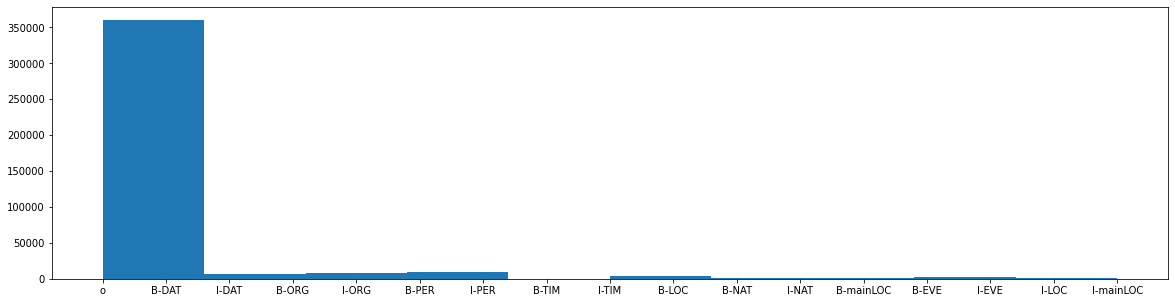

In [66]:
import matplotlib.pyplot as plt
labels_dist = []
for item in data_train['labels']:
    labels_dist = labels_dist + item

plt.figure(figsize=(20,5))
plt.hist(labels_dist, )

In [73]:
labels, counts=np.unique(np.array(labels_dist),return_counts=True)
label_counts = {}
for label, count in zip(labels,counts):
    label_counts[label] = count
label_counts

{'B-DAT': 1434,
 'B-EVE': 772,
 'B-LOC': 2965,
 'B-NAT': 598,
 'B-ORG': 4622,
 'B-PER': 4318,
 'B-TIM': 231,
 'B-mainLOC': 469,
 'I-DAT': 1868,
 'I-EVE': 1692,
 'I-LOC': 1464,
 'I-NAT': 150,
 'I-ORG': 7499,
 'I-PER': 5070,
 'I-TIM': 275,
 'I-mainLOC': 275,
 'o': 359011}

In [11]:

from datasets import Dataset
dataset_train = Dataset.from_pandas(data_train)
dataset_val = Dataset.from_pandas(data_val)
dataset_test = Dataset.from_pandas(data_test)

### new Way

In [12]:
labels = ["B-DAT", "B-TIM", "B-PER", "B-ORG", "B-LOC", "B-EVE", "B-NAT", "B-mainLOC", "I-DAT", "I-TIM", "I-PER", "I-ORG", "I-LOC", "I-EVE", "I-NAT", "I-mainLOC", "o"]
id2label = {}
label2id = {}
for i, item in enumerate(labels):
    id2label[i] = item
    label2id[item] = i
id2label

{0: 'B-DAT',
 1: 'B-TIM',
 2: 'B-PER',
 3: 'B-ORG',
 4: 'B-LOC',
 5: 'B-EVE',
 6: 'B-NAT',
 7: 'B-mainLOC',
 8: 'I-DAT',
 9: 'I-TIM',
 10: 'I-PER',
 11: 'I-ORG',
 12: 'I-LOC',
 13: 'I-EVE',
 14: 'I-NAT',
 15: 'I-mainLOC',
 16: 'o'}

In [43]:
batch_size = 256
task = "ner" 
model_name = 'HooshvareLab/bert-fa-zwnj-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/HooshvareLab/bert-fa-zwnj-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ba5343a1268e870ceacba2041556e22a4480d6af08e330b0650f96c96a5e50b4.967063c40b5c987b6e0d2a6d1944963280b9a53e5821fcb5379494a07dc9408d
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-zwnj-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 42000
}

loading file https://huggingface.co/Ho

In [44]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["token"]), padding="max_length",max_length= 128, truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label[word_idx]])
            else:
                label_ids.append(label2id[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [45]:
dataset_test_tokenized=dataset_test.map(tokenize_and_align_labels,batched=True)
dataset_val_tokenized = dataset_val.map(tokenize_and_align_labels,batched=True)
dataset_train_tokenized = dataset_train.map(tokenize_and_align_labels,batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [46]:
model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(id2label))
model.config.id2label = id2label
model.config.label2id = label2id
model.config._num_labels = len(id2label)
model.config.num_labels = len(label2id)
model

loading configuration file https://huggingface.co/HooshvareLab/bert-fa-zwnj-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ba5343a1268e870ceacba2041556e22a4480d6af08e330b0650f96c96a5e50b4.967063c40b5c987b6e0d2a6d1944963280b9a53e5821fcb5379494a07dc9408d
Model config BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-zwnj-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [47]:
# you should freeze all parameters except classifier
# otherwise, you will be training the BERT!!
for param in model.bert.parameters():
    param.requires_grad = False

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=1e-5,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [48]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")

In [49]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[labels[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[labels[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    

In [82]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset_train_tokenized,batch_size=batch_size)

In [83]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataloader,
    eval_dataset= dataset_val_tokenized,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [84]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 16
  Num Epochs = 10
  Instantaneous batch size per device = 256
  Total train batch size (w. parallel, distributed & accumulation) = 256
  Gradient Accumulation steps = 1
  Total optimization steps = 10


TypeError: ignored

In [ ]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: token. If token are not expected by `BertForTokenClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 34
  Batch size = 16


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'epoch': 10.0,
 'eval_accuracy': 0.9698510715583001,
 'eval_f1': 0.9704271631982476,
 'eval_loss': 0.20042768120765686,
 'eval_precision': 0.970781592403214,
 'eval_recall': 0.9700729927007299,
 'eval_runtime': 0.6131,
 'eval_samples_per_second': 55.46,
 'eval_steps_per_second': 4.894}

In [52]:
trainer.save_model('un-ner.model')

Saving model checkpoint to un-ner.model
Configuration saved in un-ner.model/config.json
Model weights saved in un-ner.model/pytorch_model.bin
tokenizer config file saved in un-ner.model/tokenizer_config.json
Special tokens file saved in un-ner.model/special_tokens_map.json


In [53]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

Didn't find file ./un-ner.model/added_tokens.json. We won't load it.
loading file ./un-ner.model/vocab.txt
loading file ./un-ner.model/tokenizer.json
loading file None
loading file ./un-ner.model/special_tokens_map.json
loading file ./un-ner.model/tokenizer_config.json


In [54]:
import torch
paragraph = '''مدیرکل محیط سازمان زیست استان البرز با بیان اینکه با بیان اینکه موضوع شیرها به های زباله های انتقال یافته در منطقه موقعیت حلقه موقعیت دره موقعیت خطری برای این استان است ، گفت : در این مورد گزارشاتی در ۲۵تاریخ مردادتاریخ ۱۳۹۷تاریخ تقدیم مدیران استان شده است .'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

torch.Size([1, 60])

In [ ]:
model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/')
predictions = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
predictions = torch.argmax(predictions.logits.squeeze(), axis=1)
predictions = [labels[i] for i in predictions]

In [56]:
words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

In [57]:
answers = pd.read_csv('./un_ner.csv')
answers

,Unnamed: 0,ner,words
0,0,o,[CLS]
1,1,o,مدیرکل
2,2,o,محیط
3,3,o,سازمان
4,4,o,زیست
5,5,o,استان
6,6,o,البرز
7,7,o,با
8,8,o,بیان
9,9,o,اینکه
